## 07_from_segmentation

> Create a half-edge mesh from a segmentation

In [ ]:
#| default_exp segmentation

In [ ]:
#| export

import CE_simulation.mesh as msh
import CE_simulation.tension as tns
import CE_simulation.delaunay as dln
import CE_simulation.isogonal as iso
import CE_simulation.drosophila as drs

In [ ]:
#| export
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from scipy import optimize, ndimage, sparse, spatial

from tqdm.notebook import tqdm

from copy import deepcopy
import pickle

In [ ]:
#| export

from typing import Union, Dict, List, Tuple, Iterable, Callable, Any
from nptyping import NDArray, Int, Float, Shape

from fastcore.foundation import patch

In [ ]:
#| export

import jax.numpy as jnp
from jax import jit
import jax
from jax.tree_util import Partial

from jax.config import config
config.update("jax_enable_x64", True) # 32 bit leads the optimizer to complain about precision loss
config.update("jax_debug_nans", False) # useful for debugging, but makes code slower!

In [ ]:
#| export

import ipywidgets as widgets
import functools
from matplotlib import animation, rc

In [ ]:
#| export

from skimage import measure, segmentation, future
import networkx as nx

In [ ]:
#| notest

import importlib

In [ ]:
importlib.reload(msh); importlib.reload(tns); importlib.reload(dln); importlib.reload(iso)

<module 'CE_simulation.isogonal' from '/home/nikolas/Documents/UCSB/streichan/numerics/code/python code/jupyter notebooks/GBE simulation/disordered simulation/CE_simulation/CE_simulation/isogonal.py'>

## Code copied from `skimage` to reduce numbers of dependencies

In [ ]:
#| export

def expand_labels(label_image, distance=1):
    """Expand labels in label image by ``distance`` pixels without overlapping.
    Given a label image, ``expand_labels`` grows label regions (connected components)
    outwards by up to ``distance`` pixels without overflowing into neighboring regions.
    More specifically, each background pixel that is within Euclidean distance
    of <= ``distance`` pixels of a connected component is assigned the label of that
    connected component.
    Where multiple connected components are within ``distance`` pixels of a background
    pixel, the label value of the closest connected component will be assigned (see
    Notes for the case of multiple labels at equal distance).
    Parameters
    ----------
    label_image : ndarray of dtype int
        label image
    distance : float
        Euclidean distance in pixels by which to grow the labels. Default is one.
    Returns
    -------
    enlarged_labels : ndarray of dtype int
        Labeled array, where all connected regions have been enlarged
    Notes
    -----
    Where labels are spaced more than ``distance`` pixels are apart, this is
    equivalent to a morphological dilation with a disc or hyperball of radius ``distance``.
    However, in contrast to a morphological dilation, ``expand_labels`` will
    not expand a label region into a neighboring region.  
    This implementation of ``expand_labels`` is derived from CellProfiler [1]_, where
    it is known as module "IdentifySecondaryObjects (Distance-N)" [2]_.
    There is an important edge case when a pixel has the same distance to
    multiple regions, as it is not defined which region expands into that
    space. Here, the exact behavior depends on the upstream implementation
    of ``scipy.ndimage.distance_transform_edt``.
    See Also
    --------
    :func:`skimage.measure.label`, :func:`skimage.segmentation.watershed`, :func:`skimage.morphology.dilation`
    References
    ----------
    .. [1] https://cellprofiler.org
    .. [2] https://github.com/CellProfiler/CellProfiler/blob/082930ea95add7b72243a4fa3d39ae5145995e9c/\
        cellprofiler/modules/identifysecondaryobjects.py#L559
    Examples
    --------
    >>> labels = np.array([0, 1, 0, 0, 0, 0, 2])
    >>> expand_labels(labels, distance=1)
    array([1, 1, 1, 0, 0, 2, 2])
    Labels will not overwrite each other:
    >>> expand_labels(labels, distance=3)
    array([1, 1, 1, 1, 2, 2, 2])
    In case of ties, behavior is undefined, but currently resolves to the
    label closest to ``(0,) * ndim`` in lexicographical order.
    >>> labels_tied = np.array([0, 1, 0, 2, 0])
    >>> expand_labels(labels_tied, 1)
    array([1, 1, 1, 2, 2])
    >>> labels2d = np.array(
    ...     [[0, 1, 0, 0],
    ...      [2, 0, 0, 0],
    ...      [0, 3, 0, 0]]
    ... )
    >>> expand_labels(labels2d, 1)
    array([[2, 1, 1, 0],
           [2, 2, 0, 0],
           [2, 3, 3, 0]])
    """

    distances, nearest_label_coords = ndimage.distance_transform_edt(label_image==0, return_indices=True)
    labels_out = np.zeros_like(label_image)
    dilate_mask = distances <= distance
    # build the coordinates to find nearest labels,
    # in contrast to [1] this implementation supports label arrays
    # of any dimension
    masked_nearest_label_coords = [dimension_indices[dilate_mask]
                                   for dimension_indices in nearest_label_coords]
    nearest_labels = label_image[tuple(masked_nearest_label_coords)]
    labels_out[dilate_mask] = nearest_labels
    return labels_out

## Creating a graph from a segmentation

Copied & slightly modified code from `skimage.future.graph`

In [ ]:
#| export

def prepare_input(img, min_area=4):
    """
    Prepare input image data for computation of cell adjacency graph.
    
    If the input image is a binary image, it is assumed to be a segmentation, and a labled image
    is created by labeling the connected components of the image. If it is not (i.e. the image contains
    more than two values), this step is skipped.
    
    Next, the image is manipulated to remove very small regions and ensure that all regions are connected
    (according to pixel connectivity 1, i.e. nearest-neighbors-no-diagonals). Non-connected components
    and small regions are deleted and filled by expanding the surrounding regions. This is done to avoid
    potential bugs when computing the neighborhood graph using morphological operations.
    
    Parameters
    ----------
    img : 2d np.array
        Either labeled image (integer type), or segmentation (binary)
    min_area : int, default 4
        Regions with smaller area are removed
    
    Returns
    -------
    lbl : 2d np.array of ints
        Sanitized labeled array
    """
    if len(np.unique(img)) == 2: # segmentation
        lbl = ndimage.label(img==0)[0]
        lbl = expand_labels(lbl, distance=2)
    else:
        lbl = img
    # remove small regions
    for key in np.unique(lbl):
        if (lbl==key).sum() == min_area:
            lbl[lbl==key] = 0 
    lbl = expand_labels(lbl, distance=2)
    # now ensure each remaining region is connected - remove all but the largest connected component.
    for key in np.unique(lbl):
        sublabled = ndimage.label(lbl==key)[0]
        subareas = {key: (sublabled==key).sum() for key in np.arange(1, np.max(sublabled)+1)}
        max_subarea = max(subareas, key=subareas.get)
        lbl[(sublabled != max_subarea) & (lbl == key)] = 0
    lbl = expand_labels(lbl, distance=2)
    return lbl

<matplotlib.image.AxesImage>

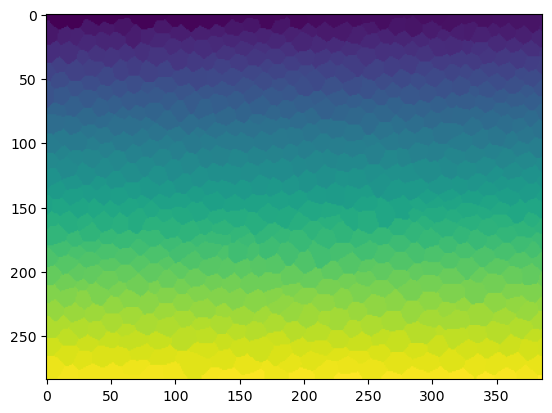

In [ ]:
## load a test segmentation & label it

segmentation_test = plt.imread('test_segmentation_small.tif')
labeled_gap = ndimage.label(segmentation_test==0)[0]
labeled_test = prepare_input(segmentation_test)

plt.imshow(labeled_test)

In [ ]:
%timeit _ = future.graph.RAG(label_image=labeled_test, connectivity=1)

120 ms ± 1.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Wheel of qualitative colors in matplotlib

Curse `matplotlib` for not providing this out of the box

In [ ]:
#| export

def for_imshow(labeled: NDArray[Shape["*,*"], Int], colors: NDArray[Shape["*,3"], Float]=drs.fridtjof_colors
              ) -> NDArray[Shape["*,*,3"], Float]:
    """Create colored array from labeled image using array of RBG colors, with black boundaries."""
    bdry = segmentation.find_boundaries(labeled, mode='outer')
    rgb = colors[labeled % colors.shape[0]]
    rgb = (rgb.transpose((2,0,1)) * (bdry == 0)).transpose((1,2,0))
    return rgb

<matplotlib.image.AxesImage>

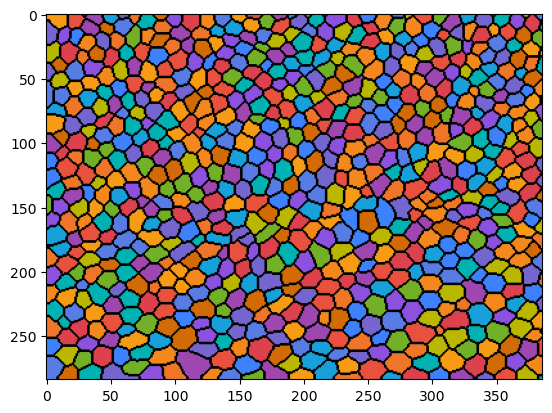

In [ ]:
plt.imshow(for_imshow(labeled_test))

### create a region connectivity graph from a labeled image.

This is copied from `skimage.future.graph` - but I don't want to depend on this module, which is currently alpha.

Graphs are modeled using dictionaries, where nodes are keys, and entries are the list of neighbors. The dictionary values are sets so as to automatically remove duplicates

In [ ]:
myset = {1, 2, 3}
myset.add(4)
myset.add(2)
myset

{1, 2, 3, 4}

In [ ]:
#| export

def _add_edge_filter(values, graph_dict):
    """Create edge in `graph_dict` between central element of `values` and the rest.
    Add an edge between the middle element in `values` and
    all other elements of `values` into `graph`.  ``values[len(values) // 2]``
    is expected to be the central value of the footprint used.
    Parameters
    ----------
    values : array
        The array to process.
    graph_dict : dict
        The graph to add edges in.
    Returns
    -------
    0 : float
        Always returns 0. The return value is required so that `generic_filter`
        can put it in the output array, but it is ignored by this filter.
    """
    values = values.astype(int)
    center = values[len(values) // 2]
    for value in values:
        if value != center:
            graph_dict[center].add(value)
    return 0.

In [ ]:
#| export

def _4fold_filter(values, graph_dict):
    """
    Create edges in `graph_dict` for 4-fold vertices which meet in the square configuration.
    
    To avoid 
    
    Parameters
    ----------
    values : array
        The array to process. Should to be of shape 4 from a 2x2 strelm
    graph_dict : dict
        The graph to add edges in.
    Returns
    -------
    0 : float
        Always returns 0. The return value is required so that `generic_filter`
        can put it in the output array, but it is ignored by this filter.
    """
    values = values.astype(int)
    if np.unique(values).size == values.size:
        graph_dict[values[0]].add(values[3])
        graph_dict[values[3]].add(values[0])
    return 0.

In [ ]:
#| export

def labeled_to_graph(label_image: NDArray[Shape["*,*"], Int], connectivity=1) -> Dict[int, set]:
    """
    Create region adjacency graph from labeled image.
    
    Returns a graph whose nodes are labeled regions in the input image, and where nodes are connected
    if they are adjacent as measured by pixel connectivity. 
    
    The graph is a dict whose keys are the nodes, and where the value at a key are the neighbors of
    a node. This code is taken from `skimage.future.graph.RAG`

    Parameters
    ----------
    label_image: 2d array of ints
        Labeled input image
    connectivity: int, default 1
        Don't change this or unexpected behavior may occur downstream.
    
    Returns
    -------
    graph_dict: dict
        Connectivity graph
    
    """

    graph_dict = {key: set() for key in np.unique(label_image)}
    fp = ndimage.generate_binary_structure(label_image.ndim, connectivity)
    # In the next ``ndi.generic_filter`` function, the kwarg
    # ``output`` is used to provide a strided array with a single
    # 64-bit floating point number, to which the function repeatedly
    # writes. This is done because even if we don't care about the
    # output, without this, a float array of the same shape as the
    # input image will be created and that could be expensive in
    # memory consumption.
    output = np.lib.stride_tricks.as_strided(np.empty((1,), dtype=float),
                                             shape=label_image.shape, strides=((0,) * label_image.ndim))
    
    ndimage.generic_filter(label_image, function=_add_edge_filter, footprint=fp, mode='nearest',
                           output=output, extra_arguments=(graph_dict,))

    fp_4fold = np.ones((2,2))
    ndimage.generic_filter(label_image, function=_4fold_filter, footprint=fp_4fold, mode='nearest',
                           output=output, extra_arguments=(graph_dict,))

    graph_dict = {int(key): val for key, val in graph_dict.items()}
    
    return graph_dict

In [ ]:
graph_test = labeled_to_graph(labeled_test)

In [ ]:
%timeit labeled_to_graph(labeled_test)

455 ms ± 2.94 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
## plot this if desired ...

## Identifiying faces

Now, we need to identify the faces, i.e. triangles. Because we are looking for triangles, i.e. length 3 cycles, this can be done in a rather brute force manner.

BAD: this identifies also triangles which are not irreducible cycles, leading to inconsistent data if the mesh contains "tetrahedron" configurations!!
 only 
One way to deal with this is to use the centroid information. The tetrahedron case is the only possibility for a non-irreducible length 3 cycle. In this case, there is a point within the a triangle that is not one of its corners.

In [ ]:
import jax.numpy as jnp
from jax import grad as jgrad
from jax import jit
from jax.config import config

config.update("jax_enable_x64", True) 

In [ ]:
#| export

def get_triangles(graph_dict):
    """Get all cycles of length 3 from a graph in dict {node: [neighbors]}-format"""
    triangles = set()
    for node in graph_dict.keys():
        for neighbor in graph_dict[node]:
            for next_neighbor in graph_dict[neighbor]:
                if node in graph_dict[next_neighbor]:
                    triangles.add(tuple(sorted([node, neighbor, next_neighbor])))
    return triangles

In [ ]:
%timeit get_triangles(graph_test)

4.53 ms ± 207 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
#| export

def is_in_tri(p, p0, p1, p2):
    A = np.stack([p1-p0, p2-p0], axis=1)
    b = p-p0
    s, t = np.linalg.solve(A, p-p0)
    return all([0 <= s <= 1, 0 <= t <= 1, s + t <= 1])

In [ ]:
p0 = np.array([0,0])
p1 = np.array([1,0])
p2 = np.array([0,1])

p = np.array([1, 1])

is_in_tri(p, p0, p1, p2)

False

## 4-fold vertices


With the connectivity-1 structuring element, the 4-fold vertex configuration cannot occur. Instead, we have the following problem. In a "square" 4-fold meeting point, _no_ diagonal link is created:
```
0 1 
3 2 
```
has links `(0,1), (1,2), (2,3), (30)`. But no others. This can be fixed by another pass with a `2x2` structuring element. 


other potentially problematic cases: highly non-convex cells which meet multiple times

<matplotlib.image.AxesImage>

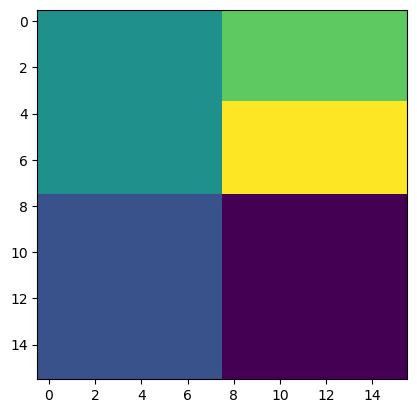

In [ ]:
## creating a test array

test_4fold = np.zeros((16, 16))

test_4fold[8:,8:] = 0
test_4fold[8:,:8] = 1
test_4fold[:8,:8] = 2
test_4fold[:4,8:] = 3
test_4fold[4:8,8:] = 4

#test_4fold[7, 8] = 2 # to trigger problem

plt.imshow(test_4fold)
# this contains 1 3-fold and one 4 fold vertex

In [ ]:
graph_4fold = labeled_to_graph(test_4fold)

graph_4fold

{0: {1, 2, 4}, 1: {0, 2}, 2: {0, 1, 3, 4}, 3: {2, 4}, 4: {0, 2, 3}}

In [ ]:
get_triangles(graph_4fold)  # missing triangles!

{(0, 1, 2), (0, 2, 4), (2, 3, 4)}

<matplotlib.image.AxesImage>

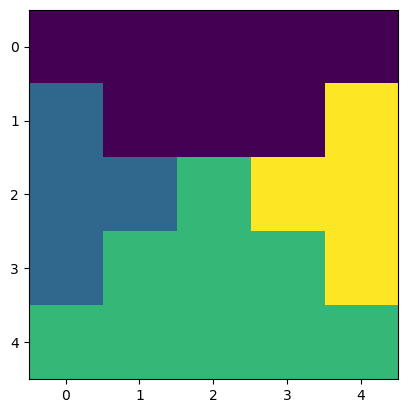

In [ ]:
test_4fold2 = np.array([[0, 0, 0, 0, 0],
                        [1, 0, 0, 0, 3],
                        [1, 1, 2, 3, 3],
                        [1, 2, 2, 2, 3],
                        [2, 2, 2, 2, 2],
                       ])

plt.imshow(test_4fold2)

In [ ]:
graph_4fold2 = labeled_to_graph(test_4fold2)

graph_4fold2

{0: {1, 2, 3}, 1: {0, 2}, 2: {0, 1, 3}, 3: {0, 2}}

In [ ]:
get_triangles(graph_4fold2)

{(0, 1, 2), (0, 2, 3)}

## temporarily set the vertices dual vertices to cell centroid positions & create `HalfEdgeMesh`

In [ ]:
#| export

def get_com_dict(labeled: NDArray[Shape["*,*"], Int]) -> Dict[int, NDArray[Shape["2"], Float]]: 
    """Get the centroids of regions in a labeled array"""
    return {key: np.array(ndimage.center_of_mass(labeled==key)) for key in np.unique(labeled)}
        

In [ ]:
%timeit get_com_dict(labeled_test)

189 ms ± 1.54 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


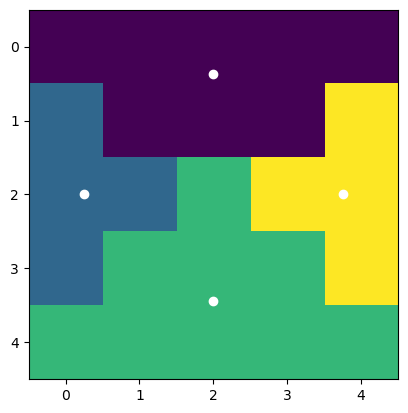

In [ ]:
plt.imshow(test_4fold2)

for val in get_com_dict(test_4fold2).values():
    plt.scatter(*val[::-1], color='w')
    

In [ ]:
tri_4fold2 = get_triangles(labeled_to_graph(test_4fold2))
points_4fold2 = get_com_dict(test_4fold2)

# re-number etc. this is problematic in as far we want the vertex labels to reflect the
# labels of the segmentation!
sorted_vertices = sorted(points_4fold2.keys())
vertex_to_ix = {key: ix for ix, key in enumerate(sorted_vertices)}

tri_4fold2 = [[vertex_to_ix[x] for x in tri] for tri in tri_4fold2]
points_4fold2 = np.array([points_4fold2[key][::-1] for key in sorted_vertices])

hemesh_4fold2 = msh.HalfEdgeMesh(msh.ListOfVerticesAndFaces(points_4fold2, tri_4fold2))

hemesh_4fold2.is_consistent()

True

<matplotlib.image.AxesImage>

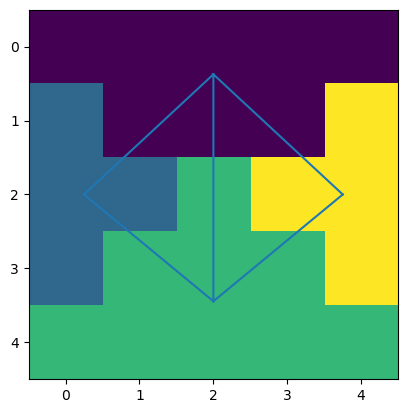

In [ ]:
hemesh_4fold2.triplot()
plt.imshow(test_4fold2)


In [ ]:
tri_4fold = get_triangles(labeled_to_graph(test_4fold))
points_4fold = get_com_dict(test_4fold)

# re-number etc. this is problematic in as far we want the vertex labels to reflect the
# labels of the segmentation!
sorted_vertices = sorted(points_4fold.keys())
vertex_to_ix = {key: ix for ix, key in enumerate(sorted_vertices)}

tri_4fold = [[vertex_to_ix[x] for x in tri] for tri in tri_4fold]
points_4fold = np.array([points_4fold[key][::-1] for key in sorted_vertices])

hemesh_4fold = msh.HalfEdgeMesh(msh.ListOfVerticesAndFaces(points_4fold, tri_4fold))

hemesh_4fold.is_consistent()

True

<matplotlib.image.AxesImage>

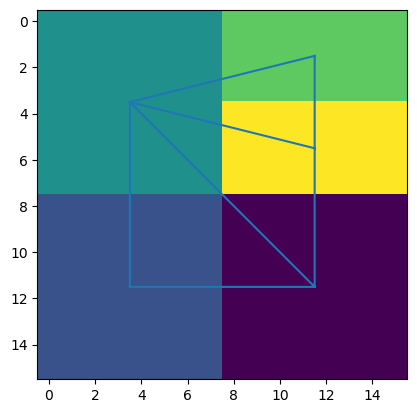

In [ ]:
hemesh_4fold.triplot()
plt.imshow(test_4fold)


## Finding primal vertices

Next, we need to find the cell vertices - corners of the cell polygons, where 3 (or more...) cells meet. And we need to match them to the corresponding triangles, too!

A vertex can be found where the 1-connectivity structuring element has two distinct neighbors

OR where the 4-vertex element exists.

so we can use similar code to the above.

By necessity, a vertex will be extended area 4 for 4 vertex area. Can shrink by skeletonize.

Then, re-dilate using 1-connectivity and find the unique elements nearby, as well as x/y coord using a for loop + numpy nonzero.

<matplotlib.image.AxesImage>

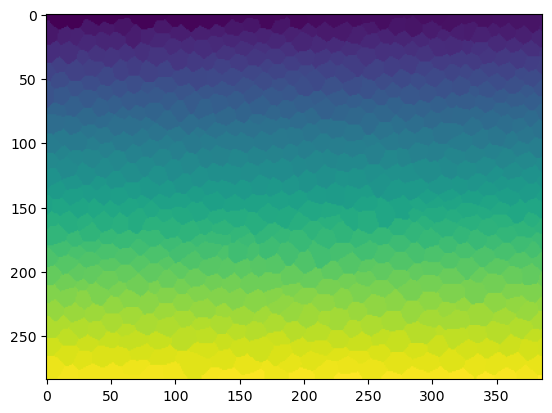

In [ ]:
plt.imshow(labeled_test)

In [ ]:
importlib.reload(msh); importlib.reload(tns); importlib.reload(dln); importlib.reload(iso)

<module 'CE_simulation.isogonal' from '/home/nikolas/Documents/UCSB/streichan/numerics/code/python code/jupyter notebooks/GBE simulation/disordered simulation/CE_simulation/CE_simulation/isogonal.py'>

In [ ]:
tri_test = get_triangles(labeled_to_graph(labeled_test))
points_test = get_com_dict(labeled_test)
points_test = {key: val[::-1] for key, val in points_test.items()}

hemesh_test = msh.HalfEdgeMesh(msh.ListOfVerticesAndFaces(points_test, tri_test))

<matplotlib.image.AxesImage>

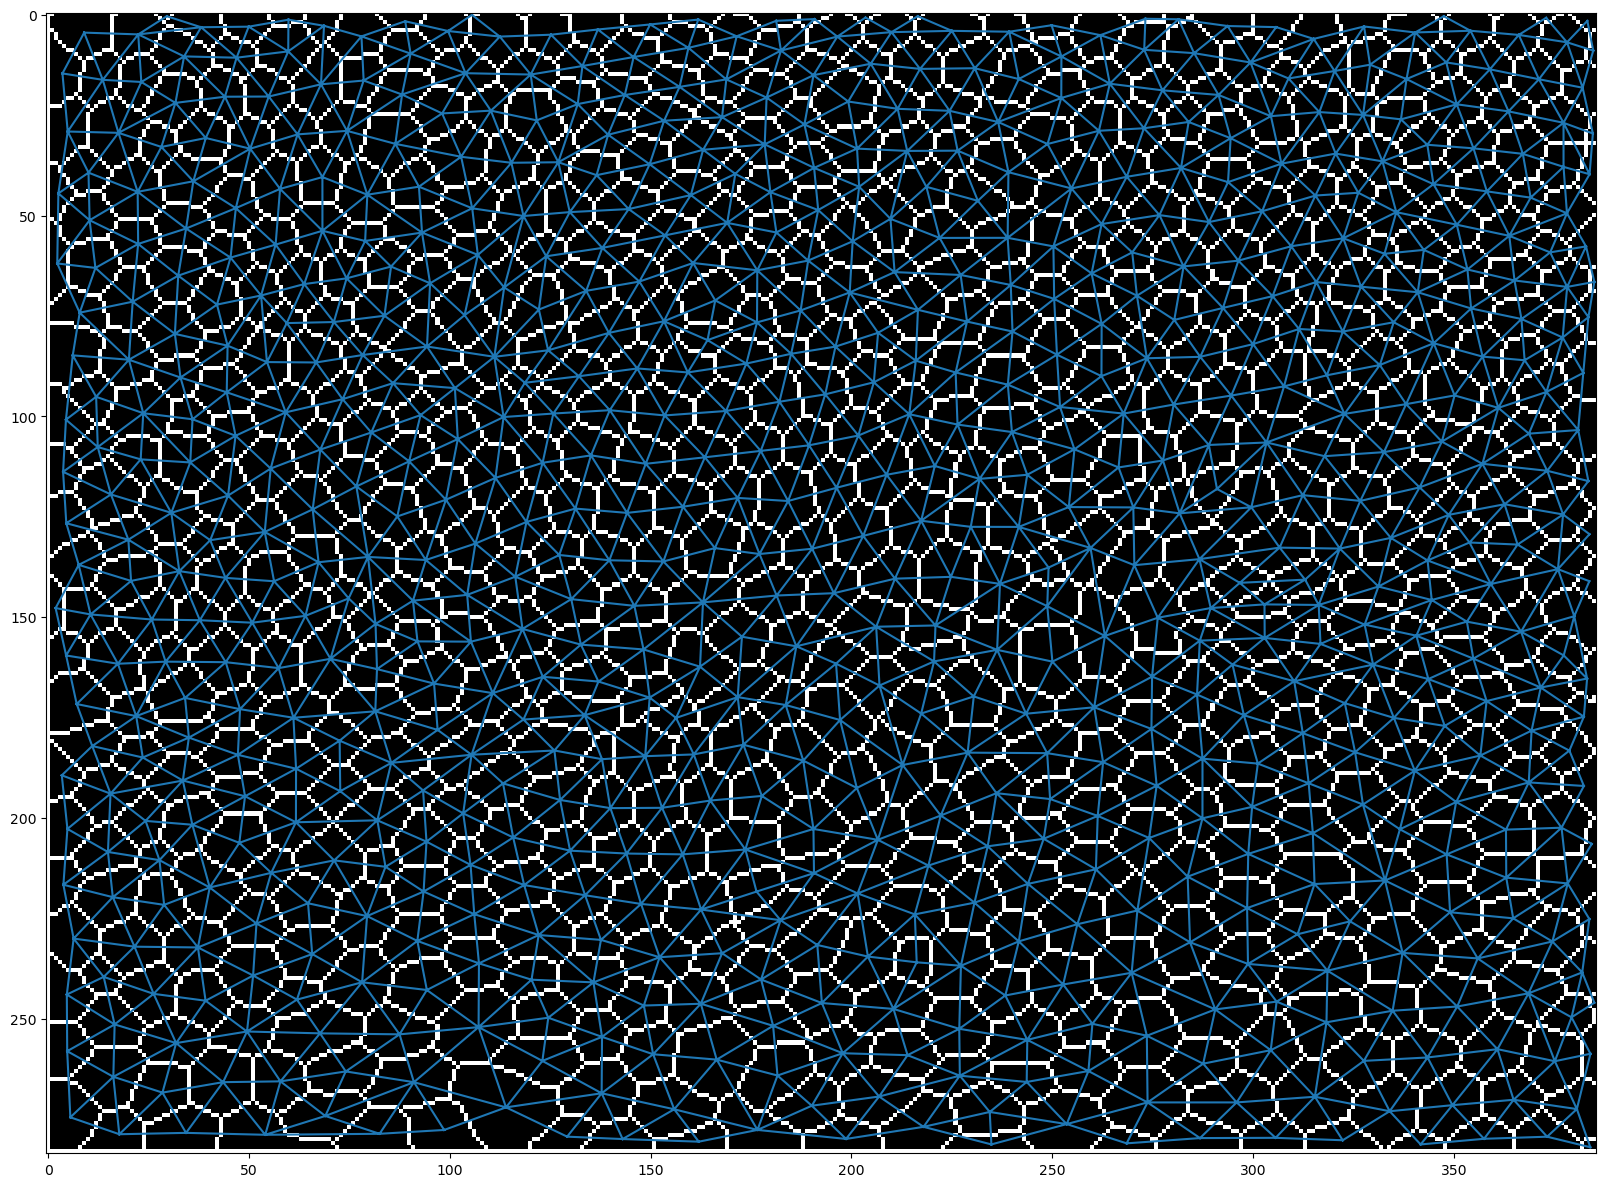

In [ ]:
fig = plt.figure(figsize=(20,20))

hemesh_test.triplot()
plt.imshow(segmentation_test, cmap="gray")


In [ ]:
%%time

cell_size = 30

for fc in hemesh_test.faces.values():
    center = np.round(fc.coords.mean(axis=0)).astype(int)
    # use take to do wraping
    windowed = labeled_test.take(range(center[1]-cell_size, center[1]+cell_size), mode='wrap', axis=0).take(
                                 range(center[0]-cell_size,center[0]+cell_size),  mode='wrap', axis=1)
    
    com = ndimage.center_of_mass(np.prod([ndimage.binary_dilation(windowed==v._vid, iterations=1)
                                          for v in fc.vertices], axis=0))
    
    
    fc.primal_coords = center + com[::-1] - np.array([cell_size, cell_size])

CPU times: user 282 ms, sys: 3.83 ms, total: 286 ms
Wall time: 286 ms


<matplotlib.image.AxesImage>

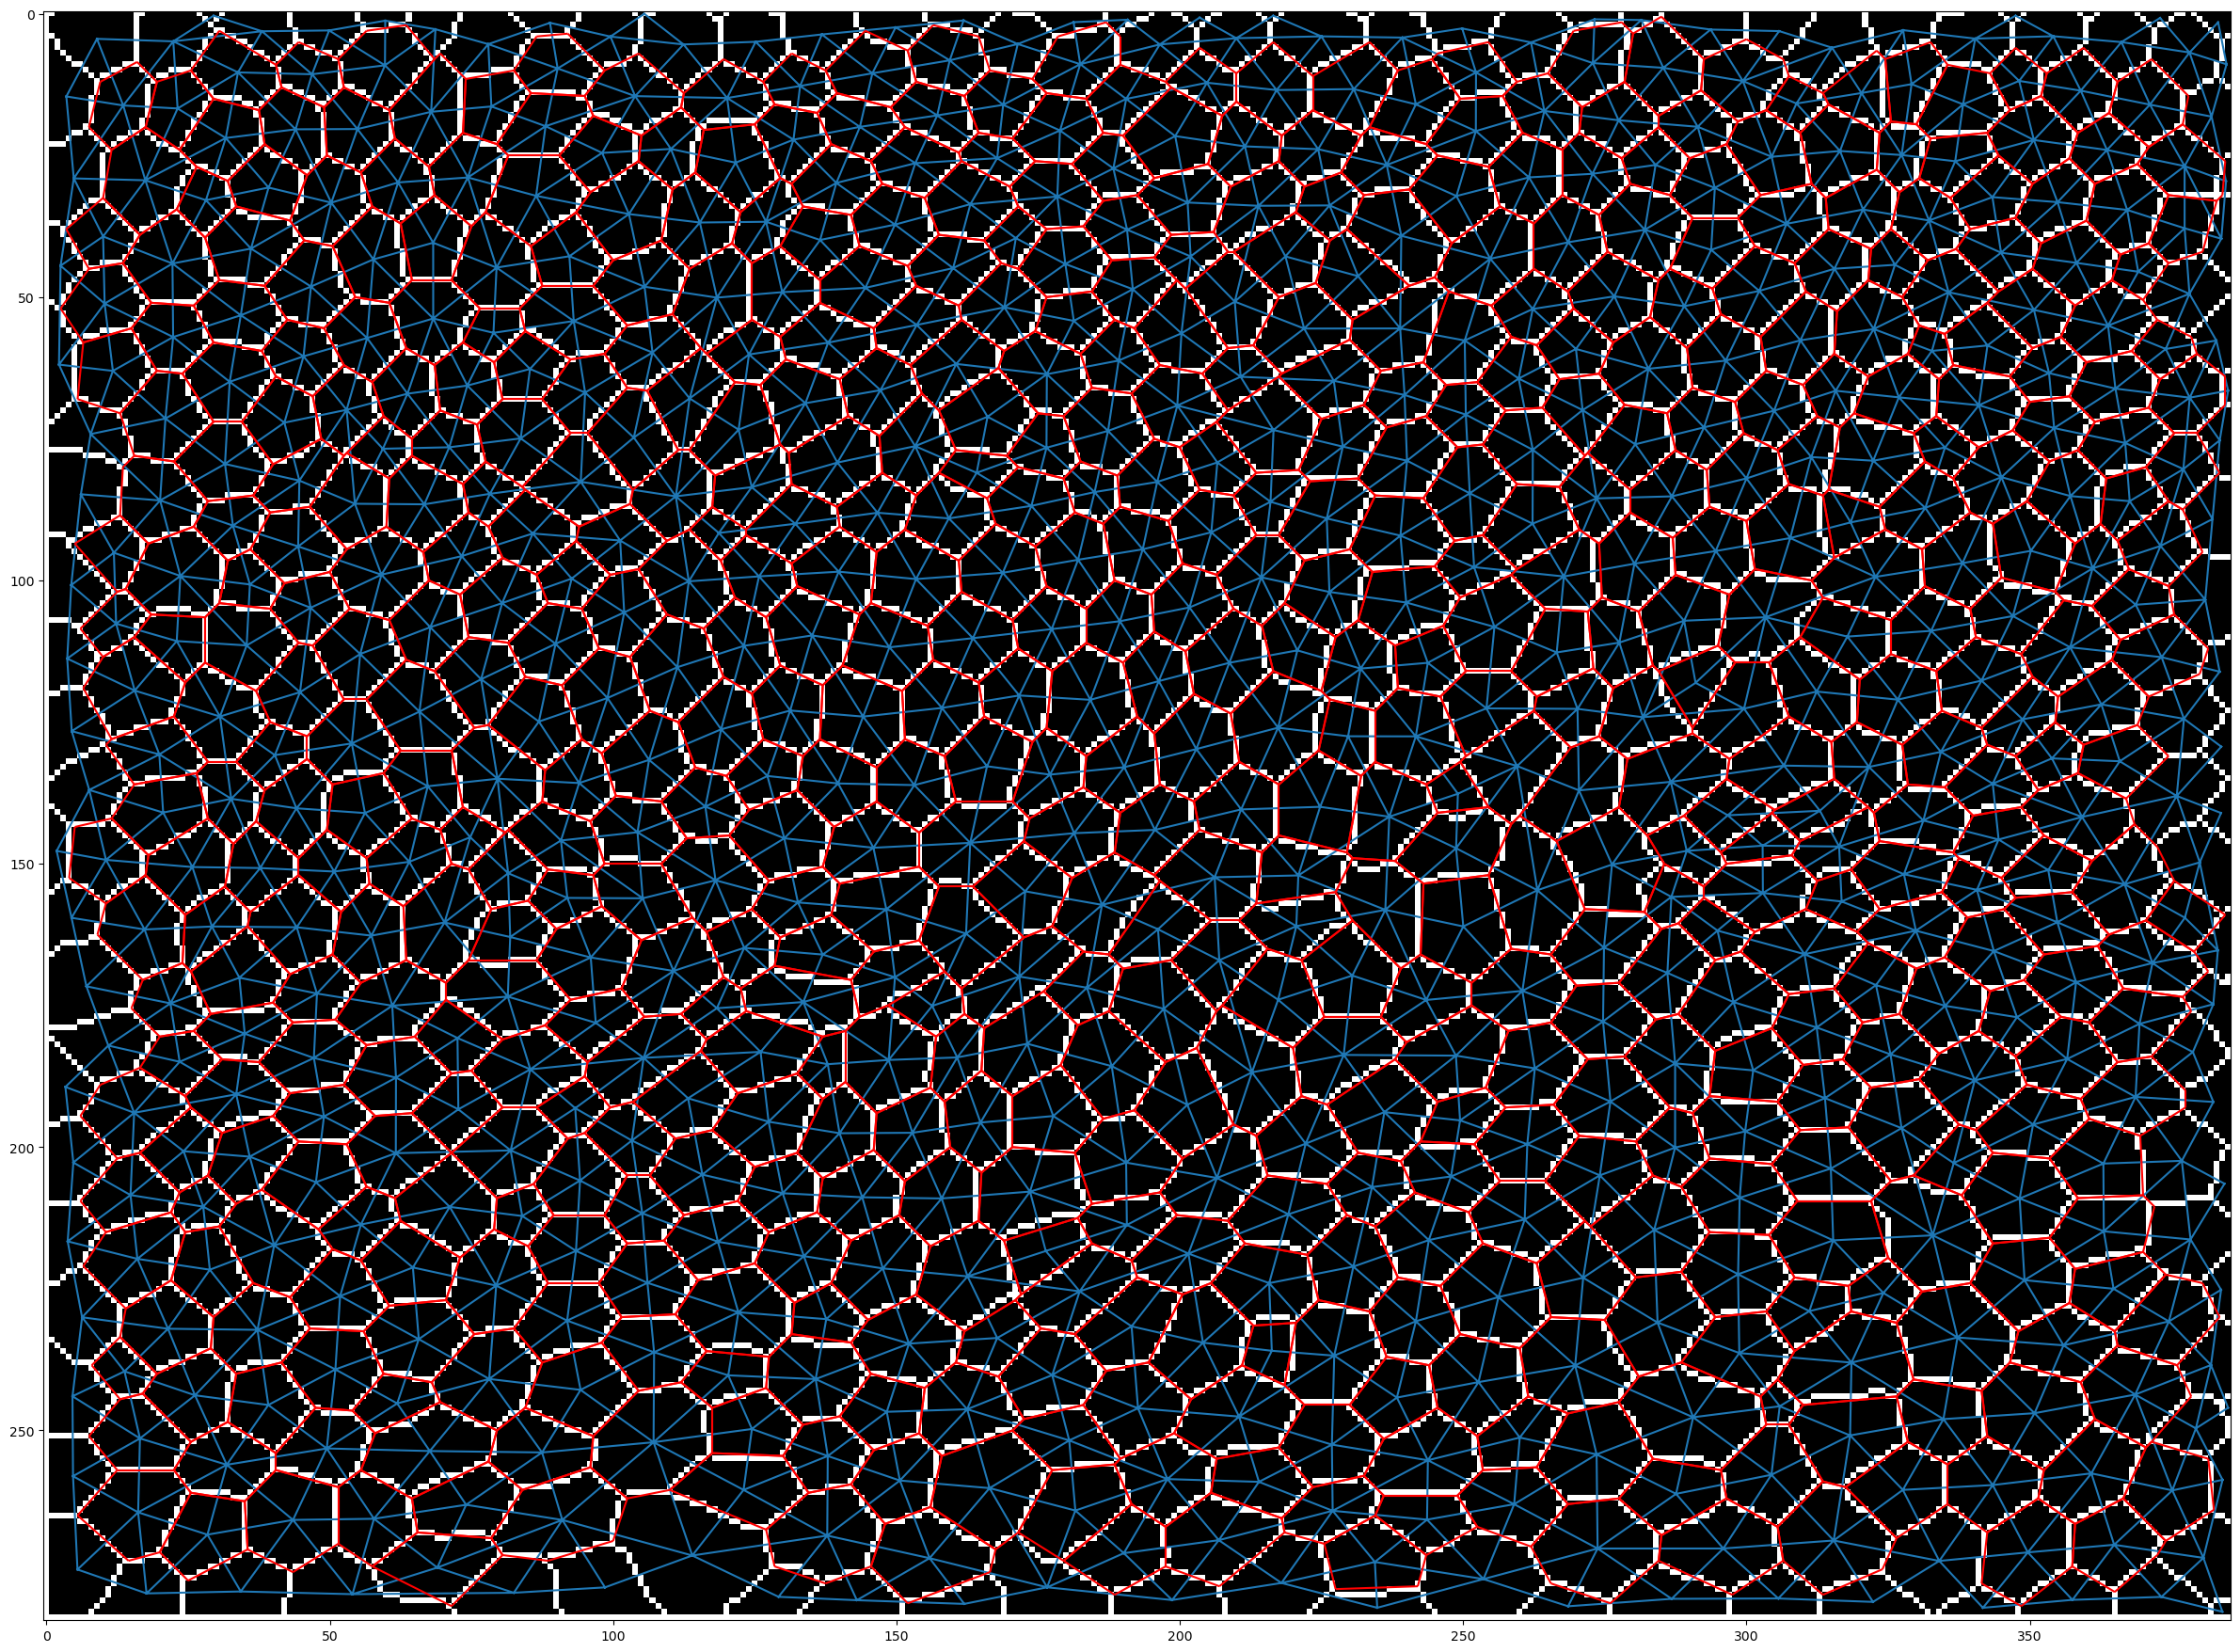

In [ ]:
fig = plt.figure(figsize=(30,30))


hemesh_test.cellplot(edge_colors={key: "r" for key in hemesh_test.hes.keys()})
hemesh_test.triplot()

plt.imshow(segmentation_test, cmap="gray")


## combine it all into a single function

In [ ]:
#| export

def touches_bdry(binary_mask):
    """Does the binary mask touch the edge?"""
    return binary_mask[:,-1].any() | binary_mask[:,0].any() | binary_mask[-1,:].any() | binary_mask[0,:].any()

def get_cells_to_remove(lbl, max_size_median_multiple=4, remove_non_convex=True, remove_singleton=True,
                        remove_boundary=False):
    """
    Find cells to remove from labeled image before creation of half-edge mesh
    
    Parameters
    ----------
    lbl : 2d np.array of ints
        Image of cell labels
    max_size_median_multiple : int, default 5
        Maximum area for cells, as a multiple of median area. Very large cells are likely background.
        If set to np.inf, no cells are removed.
    remove_non_convex : bool, default True
        Remove cells whose centroid are outside of themselves from the mesh. They typically create problems for
        the half-edge mesh.
    remove_singleton : bool, default True
        Remove cells connected to only one other cell.
    remove_boundary : bool, default False
        Remove cells connected to the boundary.
    
    Returns
    -------
    cells_to_remove : list
        List of cells to remove
    
    """
    remove_cells = []
    cells = np.unique(lbl)
    if max_size_median_multiple < np.inf:
        cell_sizes = {c: (lbl==c).sum() for c in cells}
        median_cell_size= np.median(list(cell_sizes.values()))
        remove_cells += [c for c, size in cell_sizes.items() if size > max_size_median_multiple*median_cell_size]
    if remove_non_convex:
        coms = {c: np.round(ndimage.center_of_mass(lbl==c), decimals=0).astype(int) for c in cells}
        remove_cells += [c for c, com in coms.items() if not (lbl[com[0], com[1]]==c)]
    if remove_singleton:
        connectivity_graph = labeled_to_graph(lbl)
        remove_cells += [c for c, nghbs in connectivity_graph.items() if len(nghbs) < 2]
    if remove_boundary:
        remove_cells += [c for c in cells if touches_bdry(lbl==c)]
    return remove_cells

In [ ]:
#| export

def image_to_hmesh(img, min_area=4, vertex_dil=1, cell_size=None, remove_cells=None,
                   get_cells_to_remove_args=None):
    """
    Compute half-edge mesh from image data.
    
    Input can be either a segmentation or a labeled image. Output is a half-edfge mesh, whose vertices
    are the cells in the image data. The primal vertex positions are found from the image data. The dual
    vertex positions are set to the cell centroids.
    
    The image is pre-processed to sanitize the segmentation and avoid errors in the cell adjacency graph.
    This includes using the function get_cells_to_remove() to remove cells that are likely going to pose
    a problem for the mesh creation.
    
    Currrently, the algorithm is not very fast since it uses an inefficient method for vertex position detection.
    
    
    Parameters
    ----------
    img : 2d np.array
        Image, either with two values for edges and background (in which case it is assumed to be a segmentation),
        or a separate integer for each cell (in which case it is assumed to show cell labels)
    min_area : int, default 4
        Minimum area for cells. Very small cells can lead to bugs
    vertex_dil : int, default 1
        Number of dilations used to determine vertex positions
    cell_size : int
        Approximate cell diameter for croppimg image when doing vertex detection. If None, is set automatically.
    get_cells_to_remove_args : dict
        Arguments for get_cells_to_remove
    
    Returns
    -------
    hemesh : HalfEdgeMesh
        Half edge mesh representing the image data
    
    """
    # sanitize input, convert segmentation to labeld if required
    lbl = prepare_input(img)
    remove_cells = [] if remove_cells is None else remove_cells
    get_cells_to_remove_args = {} if get_cells_to_remove_args is None else get_cells_to_remove_args
    # automatically find problematic cells
    remove_cells += get_cells_to_remove(lbl, **get_cells_to_remove_args)
    # compute adjaceny graph and create half-edge mesh
    tris = get_triangles(labeled_to_graph(lbl))
    points = get_com_dict(lbl)
    points = {key: val[::-1] for key, val in points.items()}
    if remove_cells is not None:
        points = {key: val for key, val in points.items() if not key in remove_cells}
        tris = [val for val in tris if not any([x in remove_cells for x in val])]
    
    # detect and remove duplicate triangles ("tetrahedron" configurations)
    tris = [fc for fc in tris if not any([is_in_tri(p, points[fc[0]], points[fc[1]], points[fc[2]])
                                          for key, p in points.items() if not key in fc])]
    
    hemesh = msh.HalfEdgeMesh(msh.ListOfVerticesAndFaces(points, tris), strict=True)

    if cell_size is None:
        cell_size = int(np.ceil(np.quantile(list(hemesh.get_edge_lens().values()), .95)))
    
    # set vertex positions
    for fc in hemesh.faces.values():
        center = np.round(fc.coords.mean(axis=0)).astype(int)
        # use take to wrap around edges
        windowed = lbl.take(range(center[1]-cell_size, center[1]+cell_size), mode='wrap', axis=0).take(
                            range(center[0]-cell_size,center[0]+cell_size),  mode='wrap', axis=1)
        com = ndimage.center_of_mass(np.prod([ndimage.binary_dilation(windowed==v._vid, iterations=1)
                                              for v in fc.vertices], axis=0))
        fc.primal_coords = center + com[::-1] - np.array([cell_size, cell_size])    
        
    return hemesh

In [ ]:
%%time

hemesh_test = image_to_hmesh(segmentation_test)

# 250 ms for input image sanitation
# 500 ms for adjacency graph
# 250 ms for centroid positions
# 250 ms for vertex positions

# tetrahedron detection takes most time

CPU times: user 10.8 s, sys: 57.1 ms, total: 10.9 s
Wall time: 10.8 s


<matplotlib.image.AxesImage>

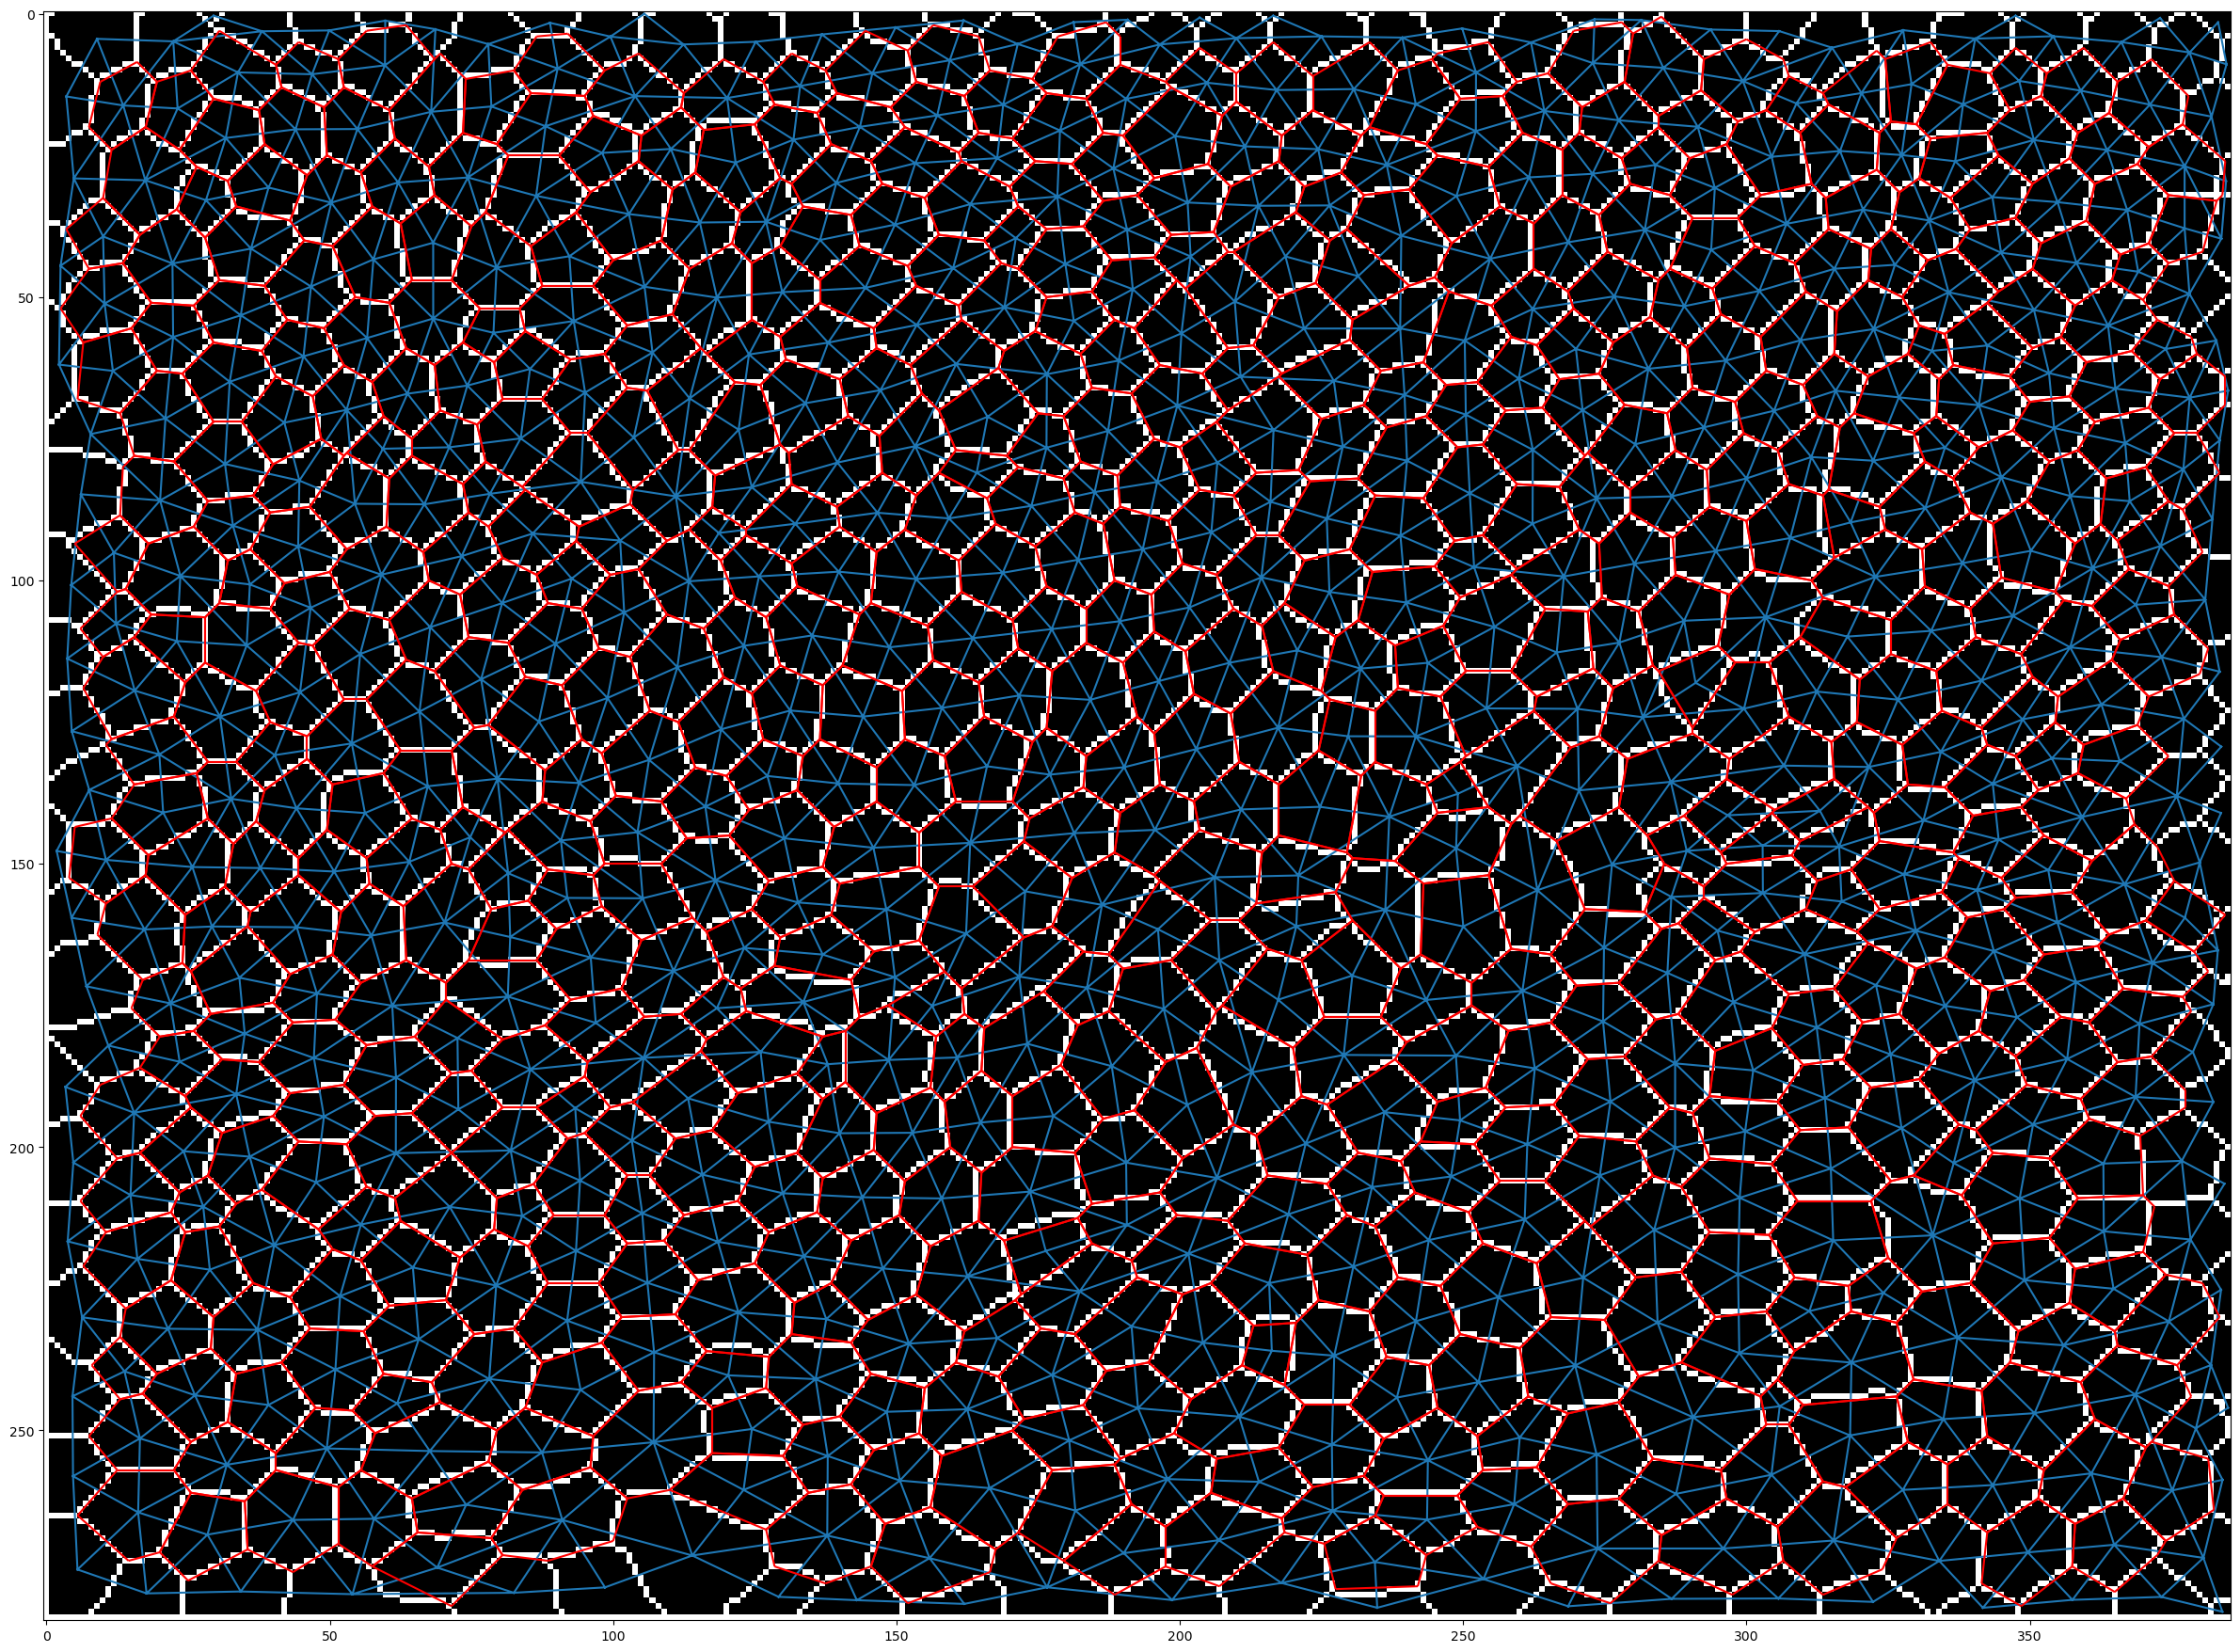

In [ ]:
fig = plt.figure(figsize=(30,30))

hemesh_test.cellplot(edge_colors={key: "r" for key in hemesh_test.hes.keys()})
hemesh_test.triplot()

plt.imshow(segmentation_test, cmap="gray")

### Force inference

In [ ]:
#| export

def normalize(x):
    return x / np.linalg.norm(x)

@patch
def infer_rel_tension(self: tns.TensionHalfEdge):
    """
    Infer relative tension on a half-edge, given the face primal coordinates.
    
    In case inference fails, returns nans
    """
    try:
        # assemble the primal vertices
        v1 = self.face.primal_coords
        v2 = self.twin.face.primal_coords
        va = self.prev.twin.face.primal_coords
        vb = self.nxt.twin.face.primal_coords
        vc = self.twin.nxt.twin.face.primal_coords
        vd = self.twin.prev.twin.face.primal_coords
        # compute the unit vectors along the edge and assemble into matrix
        n12 = normalize(v2-v1)
        n1a = normalize(va-v1)
        n1b = normalize(vb-v1)
        n2c = normalize(vc-v2)
        n2d = normalize(vd-v2)
        N = np.stack([np.hstack([n12, -n12, 2/6]),
                      np.hstack([n1a, np.zeros(2), 1/6]),
                      np.hstack([n1b, np.zeros(2), 1/6]),
                      np.hstack([np.zeros(2), n2c, 1/6]),
                      np.hstack([np.zeros(2), n2d, 1/6])]).T
        # solve for tensions
        Ts_inferred = np.linalg.solve(N, np.array([0,0,0,0,1]))
        T_central = Ts_inferred[0] / Ts_inferred[1:].mean()
    except (AttributeError, np.linalg.LinAlgError) as e: # boundary or non-solvable
        T_central = np.nan
    return T_central

In [ ]:
#| export

from matplotlib.colors import LinearSegmentedColormap

bgr =  LinearSegmentedColormap.from_list('my_gradient', (
    # Edit this gradient at https://eltos.github.io/gradient/#0032F5-0032F5-7A7A7A-F1030F-F10410
    (0.000, (0.000, 0.196, 0.961)),
    (0.250, (0.000, 0.196, 0.961)),
    (0.500, (0.478, 0.478, 0.478)),
    (0.750, (0.945, 0.012, 0.059)),
    (1.000, (0.945, 0.016, 0.063))))

def get_color(x, vmin=.5, vmax=1.6):
    return np.array(bgr((np.clip(x, vmin, vmax)-vmin)/(vmax-vmin)))
    

In [ ]:
# test using some mesh

test_mesh, _ = drs.create_rect_initial(10, 10, initial_strain=0.1, noise=0.2)

(-4.237020173768078, 4.148898883050974, -4.780338971515617, 4.8790663355359065)

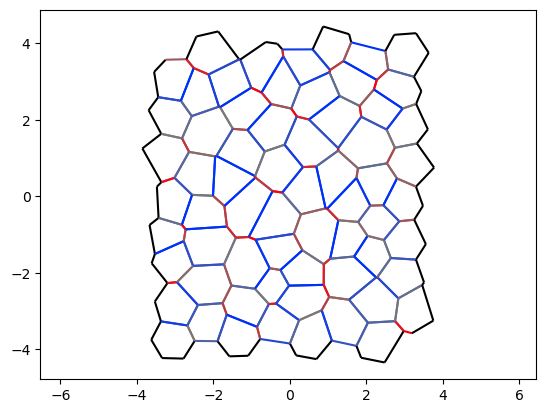

In [ ]:
rel_tension_test_mesh = {key: he.infer_rel_tension() for key, he in test_mesh.hes.items()}


test_mesh.cellplot(edge_colors={key: get_color(val) for key, val in rel_tension_test_mesh.items()})
plt.axis("equal")

In [ ]:
ground_truth = test_mesh.get_rel_tension()

#infered_vs_true = np.stack([(he.infer_rel_tension(), np.linalg.norm(he.vertices[1].coords-he.vertices[0].coords))
#                            for he in test_mesh.hes.values()])
infered_vs_true = np.stack([(rel_tension_test_mesh[key], val) for key, val in ground_truth.items()])
infered_vs_true = infered_vs_true[~np.isnan(infered_vs_true[:,0]),:]

In [ ]:
np.corrcoef(infered_vs_true[:,0], infered_vs_true[:,1])[1,0]

0.9167936697653801

[<matplotlib.lines.Line2D>]

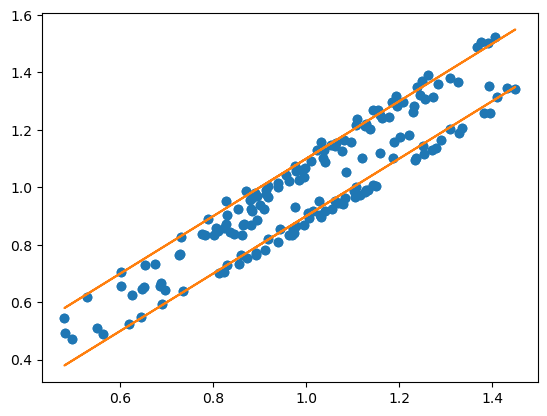

In [ ]:
plt.scatter(*infered_vs_true.T) # looks OK. likely no bug. why are there two lines though?

plt.plot(infered_vs_true[:,0], infered_vs_true[:,0]+0.1, color="tab:orange")
plt.plot(infered_vs_true[:,0], infered_vs_true[:,0]-0.1, color="tab:orange")

### Functions for analysis of inferred tensions

In [ ]:
#| export

def get_moving_avg(x, y, dx, statistic=np.mean, sampling=None):
    """
    Get moving average over unequally spaced data.
    
    Parameters
    ----------
    x : 1d np.array
        Positions of data points
    y : 1d np.array
        Values of data points
    dx : float
        window size
    statistic: callable
        Function to compute, default: np.mean
    sampling: None or float
        Approx. spacing of sample points. Defaults to dx/2
        
    Returns
    -------
    sample_pts : 1d np.array
        Points at which moving_avg was computed
    moving_avg : 1d np.array
        Value of the average
    
    """
    sampling = dx/2 if sampling is None else sampling
    moving_avg = []
    N = int(np.round((x.max()-x.min()-dx)/sampling))    
    sample_pts = np.linspace(x.min()+dx/2, x.max()-dx/2, N)
    for x0 in sample_pts:
        moving_avg.append(statistic(y[np.abs(x-x0) < dx/2]))
        
    return sample_pts, np.array(moving_avg)


In [ ]:
#| export

def get_aniso(tensor):
    vals = np.linalg.eigvalsh(tensor)
    return (vals[1]-vals[0])/(vals[1]+vals[0])

In [ ]:
#| export

def get_stress_tensors_inferred(mesh, inferred_tensions, quadratic=False):
    """
    Compute 2d stress tensor at mesh vertices using the inferred tensions.
    
    Parameters
    ----------
    mesh : Half Edge mesh
    inferred_tensions : dict he._heid: float
        Inferred tensions
    quadratic : bool
        Compute quadratic stress tensor T\otimes T or linear stress tensor T \otimes n
        
    Returns
    -------
    stress_tens_dict : dict
        2d stress tensors at each vertex. No entries are created for edge vertices where tensions are undefined.
    
    """
    stress_tens_dict = {}

    for key, fc in mesh.faces.items():
        try:
            v0 = fc.primal_coords
            nis = np.stack([normalize(he.twin.face.primal_coords-v0) for he in fc.hes])
            Tis = np.stack([inferred_tensions[he._heid] for he in fc.hes]) * nis.T
            if quadratic:
                stress_tens_dict[key] = 2/3*np.einsum('ie,je->ij', Tis, Tis)
            else:
                stress_tens_dict[key] = 2/3*np.einsum('ie,je->ij', Tis, nis.T)
        except AttributeError:
            continue
    return stress_tens_dict

In [ ]:
get_stress_tensors_inferred(test_mesh, rel_tension_test_mesh, quadratic=False)

{2: array([[0.7897237 , 0.05231889],
        [0.05231889, 1.24919027]]),
 3: array([[ 1.10752967, -0.09544555],
        [-0.09544555,  0.97221415]]),
 4: array([[1.54320239, 0.21053819],
        [0.21053819, 0.53464605]]),
 5: array([[1.37036464, 0.39055508],
        [0.39055508, 0.6603272 ]]),
 6: array([[ 1.03215421, -0.17299309],
        [-0.17299309,  1.14769733]]),
 8: array([[nan, nan],
        [nan, nan]]),
 10: array([[1.05163235, 0.21694967],
        [0.21694967, 0.86967657]]),
 12: array([[nan, nan],
        [nan, nan]]),
 14: array([[ 1.46450396, -0.4415355 ],
        [-0.4415355 ,  0.56391635]]),
 15: array([[1.40971894, 0.05941019],
        [0.05941019, 0.56870468]]),
 16: array([[ 1.0122028 , -0.08485898],
        [-0.08485898,  0.78784105]]),
 21: array([[nan, nan],
        [nan, nan]]),
 22: array([[1.24372236, 0.2348591 ],
        [0.2348591 , 0.87441414]]),
 23: array([[1.02150393, 0.19471971],
        [0.19471971, 0.87784062]]),
 24: array([[ 1.28684666, -0.32960168]

### Force inference with 3d coordinates

Often, the image data we are interested is coming from maps of curved surfaces. We need to use the actual 3d coordinates of the vertices to compute the tensions. We assume that we have 3 images, of the same shape as the segmentation, that provide the x/y/z coordinates of the image locations. These can then be read into the half-edge mesh.

In [ ]:
tns.TensionHalfEdgeMesh

CE_simulation.tension.TensionHalfEdgeMesh

In [ ]:
#| export

@patch
def read_3d_coords(self: tns.TensionHalfEdgeMesh, embedding):
    """
    Read in 3d coordinates for mesh vertices and faces.
    
    Sets the attributes v.coords_3d and fc.primal_coords_3d for vertices v and faces fc.
    Assumes that the vertex coordinates and face primal coordinates are the pixel locations of the vertices/faces
    in the "embdedding" image. This is true if mesh was created from a segmentation with embedding map embedding.
    
    Parameters
    ----------
    embedding : np.array of shape (3, width, height) 
        Inferred tensions
        
    Returns
    -------
    None
    """

    for v in self.vertices.values():
        v.coords_3d = embedding[:, np.round(v.coords[1]).astype(int), np.round(v.coords[0]).astype(int)]
    for fc in self.faces.values():
        fc.primal_coords_3d = embedding[:, np.round(fc.primal_coords[1]).astype(int),
                                        np.round(fc.primal_coords[0]).astype(int)]
    return None

In [ ]:
#| export

@patch
def infer_rel_tension_3d(self: tns.TensionHalfEdge):
    """
    Infer relative tension on a half-edge, given the face primal coordinates in 3d.
    """

    try:
        # assemble the primal vertices
        v1 = self.face.primal_coords_3d
        v2 = self.twin.face.primal_coords_3d
        va = self.prev.twin.face.primal_coords_3d
        vb = self.nxt.twin.face.primal_coords_3d
        vc = self.twin.nxt.twin.face.primal_coords_3d
        vd = self.twin.prev.twin.face.primal_coords_3d
        # subtract mean, project to local tangent plane
        coords_all = np.stack([v1, v2, va, vb, vc, vd])
        coords_all = coords_all - coords_all.mean(axis=0)
        svd = np.linalg.svd(coords_all, full_matrices=False)
        normal = svd.Vh[-1,:]
        tangents = svd.Vh[:-1,:]
        coords_all_projected = coords_all @ tangents.T
        
        v1, v2, va, vb, vc, vd = coords_all_projected
        # compute the unit vectors along the edge and assemble into matrix
        n12 = normalize(v2-v1)
        n1a = normalize(va-v1)
        n1b = normalize(vb-v1)
        n2c = normalize(vc-v2)
        n2d = normalize(vd-v2)
        N = np.stack([np.hstack([n12, -n12, 2/6]),
                      np.hstack([n1a, np.zeros(2), 1/6]),
                      np.hstack([n1b, np.zeros(2), 1/6]),
                      np.hstack([np.zeros(2), n2c, 1/6]),
                      np.hstack([np.zeros(2), n2d, 1/6])]).T
        # solve for tensions
        Ts_inferred = np.linalg.solve(N, np.array([0,0,0,0,1]))
        T_central = Ts_inferred[0] / Ts_inferred[1:].mean()
    except (AttributeError, np.linalg.LinAlgError) as e: # boundary
        T_central = np.nan
    return T_central

In [ ]:
#| export

def get_stress_tensors_inferred_3d(mesh, inferred_tensions, quadratic=False):
    """
    Compute stress tensor at mesh vertices, in 3d, using the inferred tensions.
    
    This function computes the stress tensors in 3d.
    
    Parameters
    ----------
    mesh : Half Edge mesh
    inferred_tensions: dict he._heid: float
        Inferred tensions. You should probably infer these tensions in 3d
    quadratic : bool
        Compute quadratic stress tensor T\otimes T or linear stress tensor T \otimes n
        
    Returns
    -------
    stress_tens_dict : dict
        3d stress tensors at each vertex. No entries are created for edge vertices where tensions are undefined.
    
    """
    stress_tens_dict = {}

    for key, fc in mesh.faces.items():
        try:
            v0 = fc.primal_coords_3d
            nis = np.stack([normalize(he.twin.face.primal_coords_3d-v0) for he in fc.hes])
            Tis = np.stack([inferred_tensions[he._heid] for he in fc.hes])
            Tis = Tis * nis.T
            if quadratic:
                stress_tens_dict[key] = 2/3*np.einsum('ie,je->ij', Tis, Tis)
            else:
                stress_tens_dict[key] = 2/3*np.einsum('ie,je->ij', Tis, nis.T)
        except AttributeError:
            continue
    return stress_tens_dict

In [ ]:
#| export

def get_stress_tensors_inferred_projected(mesh, inferred_tensions, e, quadratic=False):
    """
    Compute stress tensor at mesh vertices, projected to 2d, using the inferred tensions.
    
    This function computes the stress tensors in 3d, and then computes a local tangent plane to project
    it into 2d. The local tanget plane is spanned by the n Cross e and n Cross (n Cross e) where n is
    the local normal and e is a 3d unit vector chosen by the user.
    
    Parameters
    ----------
    mesh : Half Edge mesh
    inferred_tensions: dict he._heid: float
        Inferred tensions. You should probably infer these tensions in 3d
    e : np.array of shape 3
        3d unit vector for orientation of tangent plane.
    quadratic : bool
        Compute quadratic stress tensor T\otimes T or linear stress tensor T \otimes n
        
    Returns
    -------
    stress_tens_dict : dict
        2d stress tensors at each vertex. No entries are created for edge vertices where tensions are undefined.
    
    """
    stress_tens_dict = {}

    for key, fc in mesh.faces.items():
        try:
            v0 = fc.primal_coords_3d
            vis = np.stack([he.twin.face.primal_coords_3d for he in fc.hes])
            nis = np.stack([(vi - v0)/np.linalg.norm(vi-v0) for vi in vis]) # index 0: edge. index 1: coordinate
            # local tangent plane projection
            coords_all = np.vstack([[v0], vis])
            coords_all = coords_all - coords_all.mean(axis=0)
            svd = np.linalg.svd(coords_all, full_matrices=False)
            normal = svd.Vh[-1,:]
            e_1 = normalize(np.cross(normal, e))
            e_2 = normalize(np.cross(normal, e_1))
            nis = np.stack([[ni.dot(e_1), ni.dot(e_2)]for ni in nis])
            Tis = np.stack([inferred_tensions[he._heid] for he in fc.hes])
            Tis = Tis * nis.T
            if quadratic:
                stress_tens_dict[key] = 2/3*np.einsum('ie,je->ij', Tis, Tis)
            else:
                stress_tens_dict[key] = 2/3*np.einsum('ie,je->ij', Tis, nis.T)
        except AttributeError:
            continue
    return stress_tens_dict

In [ ]:
stress_tensors_local_normal = {}

for key, fc in mesh_3d.faces.items():
    try:
        v0 = fc.primal_coords_3d
        vis = np.stack([he.twin.face.primal_coords_3d for he in fc.hes])
        nis = np.stack([(vi - v0)/np.linalg.norm(vi-v0) for vi in vis]) # index 0: edge. index 1: coordinate
        # local tangent plane projection
        coords_all = np.vstack([[v0], vis])
        coords_all = coords_all - coords_all.mean(axis=0)
        svd = np.linalg.svd(coords_all, full_matrices=False)
        normal = svd.Vh[-1,:]
        e_DV = seg.normalize(np.cross(normal, np.array([0,1,0])))
        e_AP = seg.normalize(np.cross(normal,  e_DV))
        nis = np.stack([[ni.dot(e_DV), ni.dot(e_AP)]for ni in nis])
        Tis = np.stack([rel_tensions_3d[he._heid] for he in fc.hes])
        Tis = np.clip(Tis, T_min, T_max)
        Tis = Tis * nis.T
        stress_tensors_local_normal[key] = np.einsum('ie,je->ij', Tis, Tis) # 2/3
        #stress_tensors_local_normal[key] = 2/3*np.einsum('ie,je->ij', Tis, nis.T)
    except AttributeError:
        continue